In [1]:
%matplotlib inline
from preamble import *

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import plotting as pl

from sklearn.metrics import confusion_matrix
import itertools

### Read in the data

In [2]:
data = pd.read_csv('data/higgs_data.csv')

higgs_85 = pd.read_csv('data/higgs_higgs_85.csv')
higgs_90 = pd.read_csv('data/higgs_higgs_90.csv')
higgs_95 = pd.read_csv('data/higgs_higgs_95.csv')
eeqq = pd.read_csv('data/higgs_eeqq.csv')
qq = pd.read_csv('data/higgs_qq.csv')
wen = pd.read_csv('data/higgs_wen.csv')
ww = pd.read_csv('data/higgs_ww.csv')
zee = pd.read_csv('data/higgs_zee.csv')
zz = pd.read_csv('data/higgs_zz.csv')


framesMC_NoHiggs = [qq, ww, zz, zee, wen, eeqq]
framesMC_NoHiggsNames = ['qq', 'ww', 'zz', 'zee', 'wen', 'eeqq']

framesMC_HiggsModels = [higgs_85, higgs_90, higgs_95]
framesMC_HiggsModelsNames = ['higgs_85', 'higgs_90', 'higgs_95']

<img src="samples_full.png"> 

### Introduce weights in order to rescale all the MC samples to the same luminosity

per definition the weight of each measured event (data) is $1$. Thus, we want to rescale the MC to the same ntegrated Luminosity of the data taking which is $L = 176.773 \ \mathrm{pb}^{-1}$

The weight for each MC sample is:
$$ 
        \mathrm{weight}_\mathrm{MC} = L \cdot  \frac{\sigma_\mathrm{MC} }{N_\mathrm{MC}}
$$

In [3]:
crossSectionsMC_noHiggs = [102., 16.5, 0.975, 3.35, 2.9, 15600.]
NumberMC_noHiggs = [200000., 294500., 196000., 29500., 81786., 5940000.]

crossSectionsMC_HiggsModels = [0.094, 0.0667, 0.0333]
NumberMC_HiggsModels = [3972., 3973., 3971.]


Lum = 176.773


weightsMC_noHiggs     = Lum*np.array(crossSectionsMC_noHiggs) / np.array(NumberMC_noHiggs) 
weightsMC_HiggsModels = Lum*np.array(crossSectionsMC_HiggsModels) / np.array(NumberMC_HiggsModels) 


#add column 'weight' to data frame of all bkg MC
for i, frame in enumerate(framesMC_NoHiggs):
    frame["weight"] = weightsMC_noHiggs[i]
    frame["class"] = 0

#add column 'weight' to data frame of all bkg+sig MC
for i, frame in enumerate(framesMC_HiggsModels):
    frame["weight"] = weightsMC_HiggsModels[i]
    frame["class"] = 1
    
#add column 'weight'=1 to data 
data["weight"] = 1



# Pick the Signal Model and produce data frames

In [22]:
signalModelindex = 0

df_MC_noHiggs = pd.concat(framesMC_NoHiggs)
df_MC_mH85 = framesMC_HiggsModels[signalModelindex]
#merge bkg and sig MC
df_mH85 = pd.concat([df_MC_noHiggs,df_MC_mH85])

## Perform selection cut analysis

In [23]:
def PickDiscVar_mH85 (df) :
    discriminating_vars = [u'btag1', u'btag2',
       u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis', u'fth1',
       u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi']+['class','weight']
    return df[discriminating_vars]

In [24]:
# choose only those columns which have some kinematical meaning and thus can be used for training
df_MVA_mH85 = PickDiscVar_mH85(df=df_mH85)

In [25]:
df_MVA_mH85.columns

Index([u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis',
       u'fth1', u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi', u'class', u'weight'],
      dtype='object')

In [26]:
# extract target values
# 0 <-> bkg
# 1 <-> sig
target = df_MVA_mH85['class']
del df_MVA_mH85['class']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_MVA_mH85, target, 
                                                    stratify=target, 
                                                    random_state=42,
                                                   train_size=0.65)
X_train_w = X_train['weight']
X_test_w = X_test['weight']


print('No of train events', len(y_train))
print('No of signal events',np.count_nonzero(y_train))
print('fraction of bkg in training set',1 - 1.*np.count_nonzero(y_train) / len(y_train))

print('-----------------------------')

print('No of test events',len(y_test))
print('No of signal events',np.count_nonzero(y_test))
print('fraction of bkg in test set',1 - 1.*np.count_nonzero(y_test) / len(y_test))


del X_train['weight']
del X_test['weight']

('No of train events', 49997)
('No of signal events', 2179)
('fraction of bkg in training set', 0.9564173850431026)
-----------------------------
('No of test events', 26922)
('No of signal events', 1174)
('fraction of bkg in test set', 0.9563925414159423)


# Initialize the Gradient Boosting Classifier

In [28]:
grbcl = GradientBoostingClassifier(max_depth=3,random_state=0,learning_rate=0.01,n_estimators=300)#,n_estimators=100,learning_rate=0.3)
grbcl.fit(X_train,y_train,sample_weight=X_train_w)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

In [29]:
print("Training set score: {:.3f}".format(grbcl.score(X_train, y_train,sample_weight=X_train_w)))
print("Test set score: {:.3f}".format(grbcl.score(X_test, y_test,sample_weight=X_test_w)))

Training set score: 0.983
Test set score: 0.983


[ 0.111  0.118  0.059  0.071  0.065  0.083  0.002  0.     0.047  0.092
  0.002  0.271  0.042  0.001  0.004  0.002  0.012  0.009  0.006  0.     0.001
  0.     0.     0.     0.     0.     0.     0.     0.001  0.     0.001  0.
  0.   ]


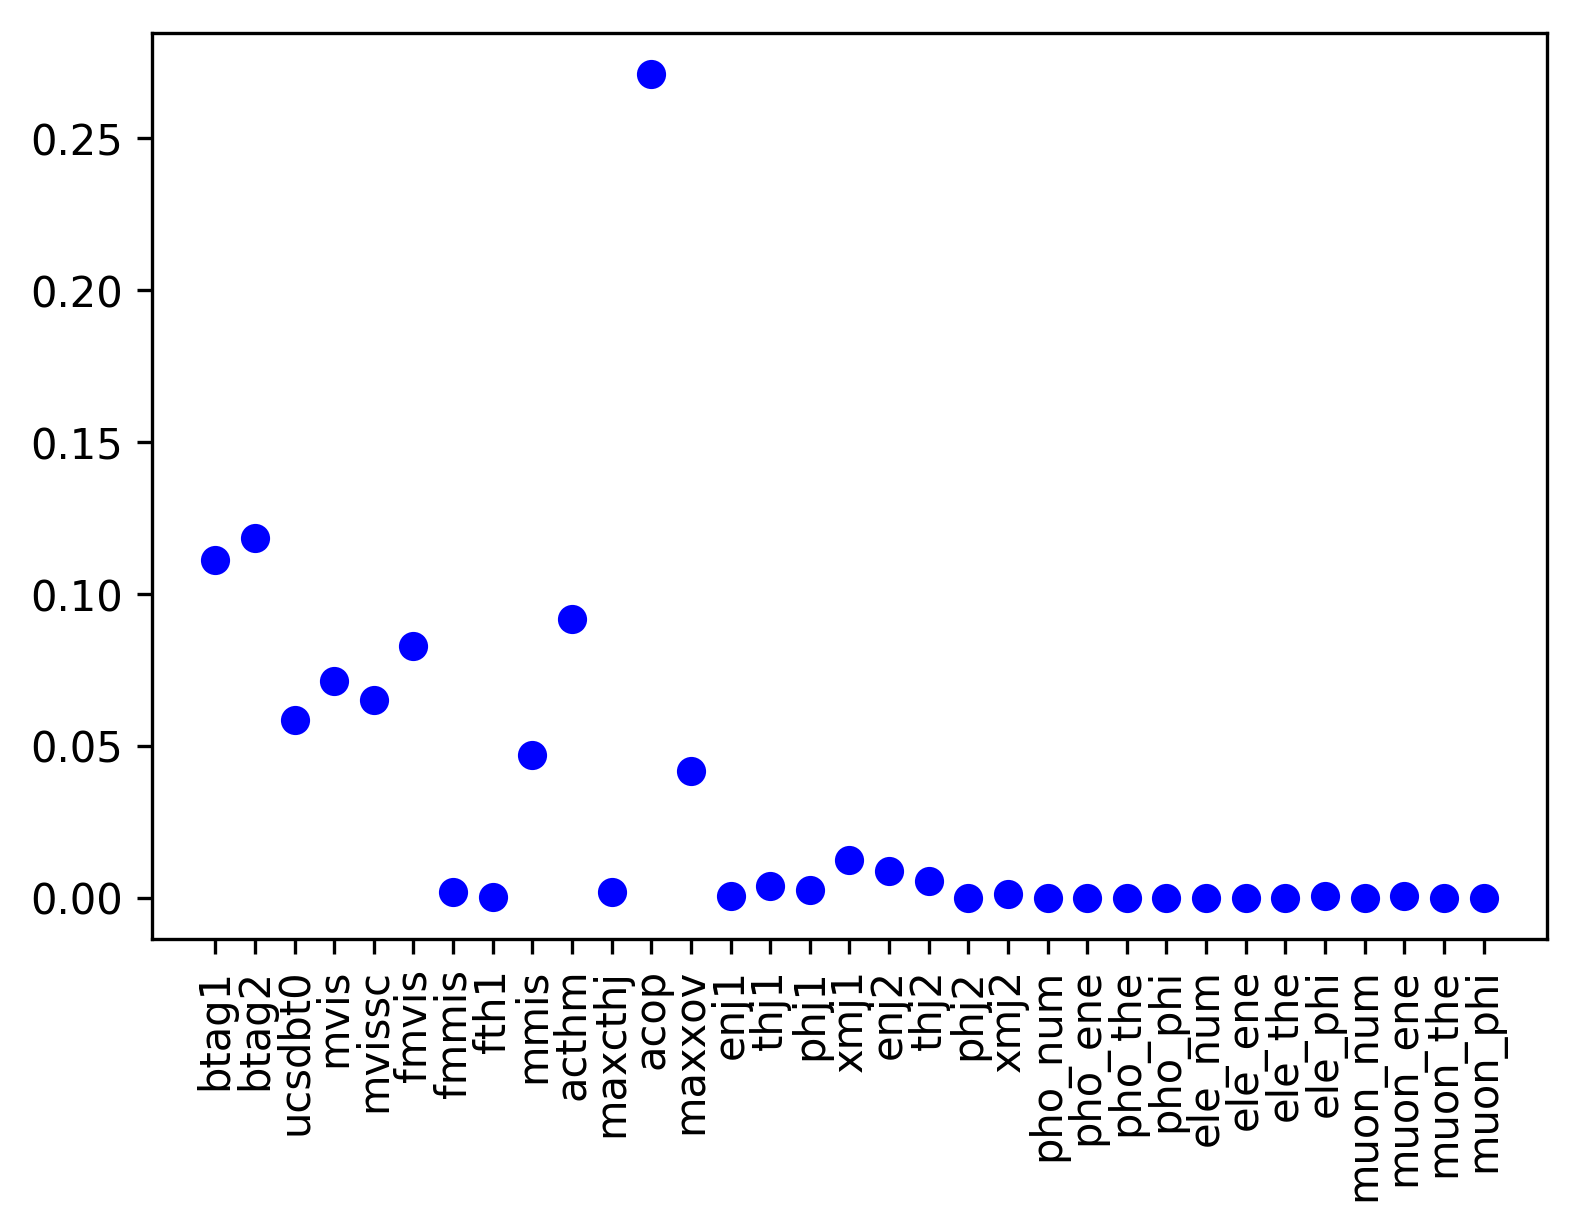

In [30]:
importance = grbcl.feature_importances_
feature = np.arange(len(X_train.columns))

print importance
fig, ax = plt.subplots()

plt.plot(feature,importance,'bo')
plt.xticks(feature)
ax.set_xticklabels(X_train.columns,rotation=90)
plt.show()

26922
26922
[[25247   501]
 [  800   374]]


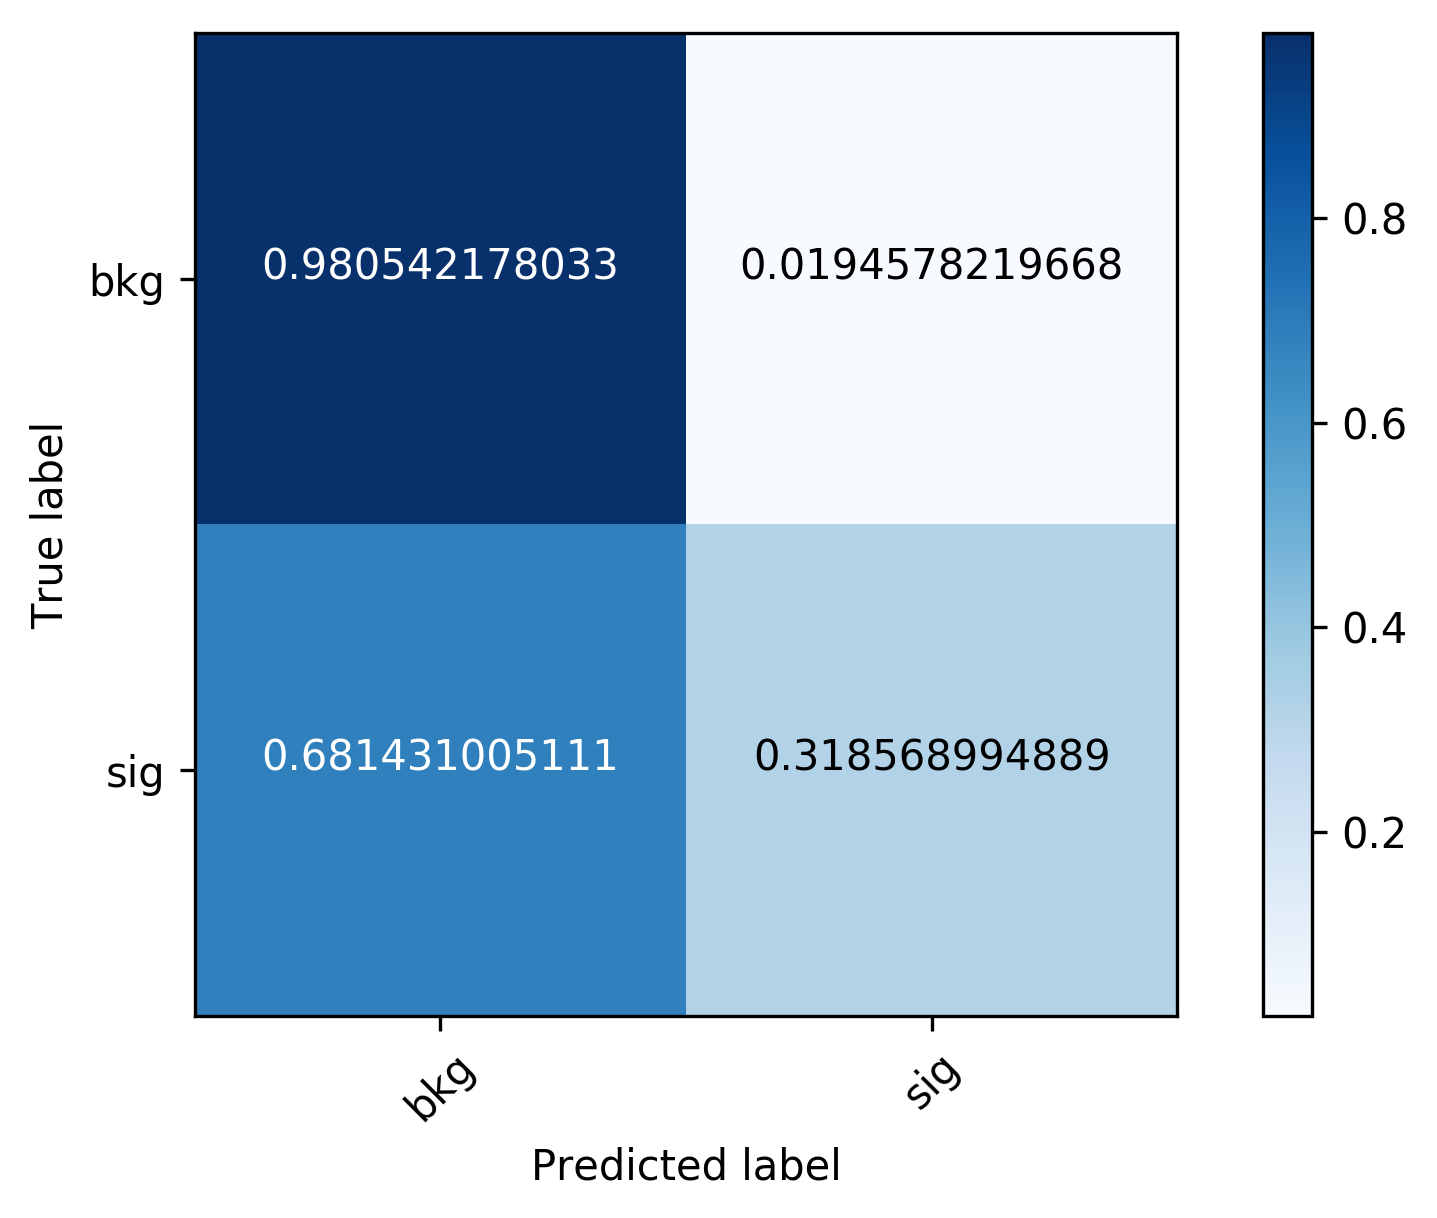

In [31]:
y_pred = grbcl.predict(X_test)

"""import cPickle
with open('BDT_85higgs.pkl', 'rb') as fid:
    gnb_loaded = cPickle.load(fid)
y_pred = gnb_loaded.predict(X_test)
"""
print(len(y_pred))
print len(y_test)

cm = confusion_matrix(y_pred,y_test)#,labels=["bkg","sig"])
cm = cm.T
print cm

cmap = plt.cm.Blues
# normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(2)
classes = ['bkg','sig']
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)



thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [32]:
X_train_df = X_train.copy()
X_train_df['class'] = y_train

X_test_df = X_test.copy()
X_test_df['class'] = y_test

In [33]:
X_train_bkg = X_train_df[X_train_df['class']==0]
X_train_sig = X_train_df[X_train_df['class']==1]
del X_train_bkg['class']
del X_train_sig['class']

X_test_bkg = X_test_df[X_test_df['class']==0]
X_test_sig = X_test_df[X_test_df['class']==1]
del X_test_bkg['class']
del X_test_sig['class']



In [34]:
# evaluate test statistics on training set
a_bkg = grbcl.decision_function(X_train_bkg)
a_sig = grbcl.decision_function(X_train_sig)

# evaluate test statistics on test set
b_bkg = grbcl.decision_function(X_test_bkg)
b_sig = grbcl.decision_function(X_test_sig)



In [35]:
print len(a_bkg)
binning = np.linspace(min(b_bkg),max(a_sig),30)
binning = np.linspace(-8,5,30)


47818


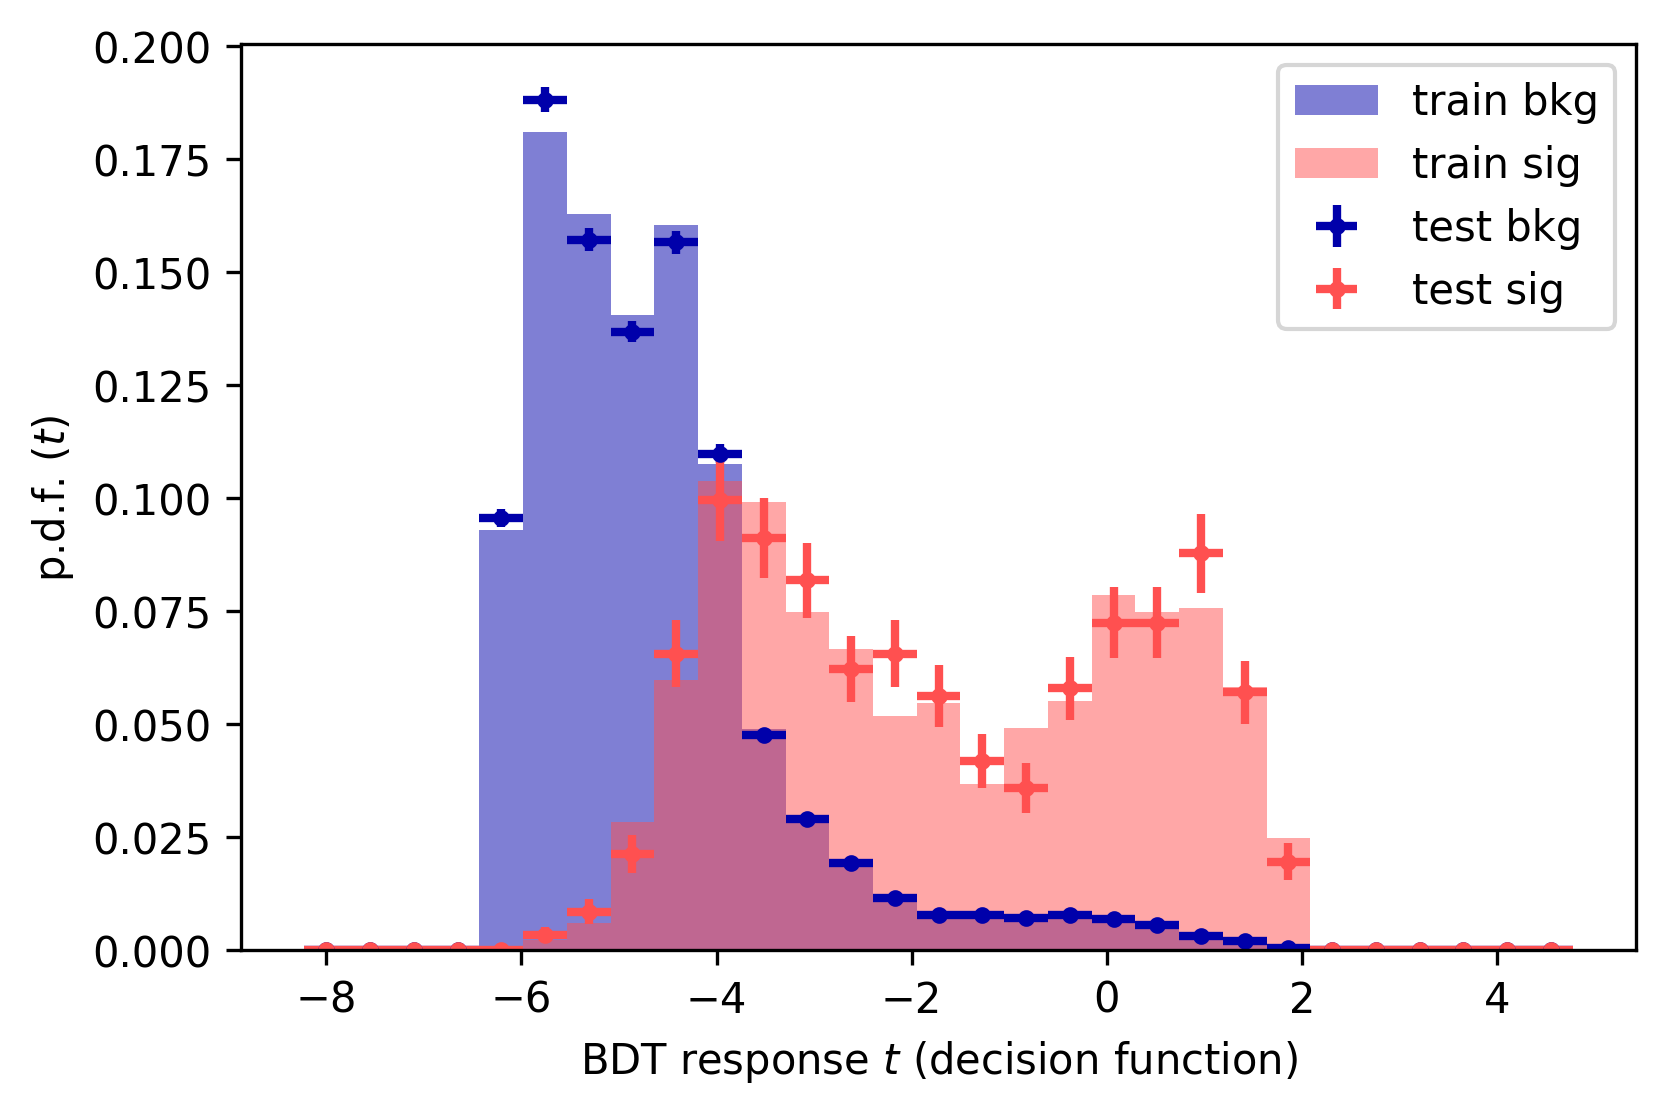

In [36]:
binw = binning[1] - binning[0]

N_a_bkg = np.histogram(a_bkg,bins=binning)[0]
norm_a_bkg = 1.*len(a_bkg)
N_a_sig = np.histogram(a_sig,bins=binning)[0]
norm_a_sig = 1.*len(a_sig)

plt.bar(left=binning[:-1],height=N_a_bkg/norm_a_bkg,width=binw,label='train bkg',alpha=0.5)
plt.bar(left=binning[:-1],height=N_a_sig/norm_a_sig,width=binw,label='train sig',alpha=0.5)


# test set part
N_bkg = np.histogram(b_bkg,bins=binning)[0]
norm_bkg = 1.*len(b_bkg)

N_sig = np.histogram(b_sig,bins=binning)[0]
norm_sig = 1.*len(b_sig)

plt.errorbar(binning[:-1],N_bkg/norm_bkg,xerr=binw/2.,label='test bkg',
            yerr=np.sqrt(N_bkg)/norm_bkg,fmt='.')
plt.errorbar(binning[:-1],N_sig/norm_sig,xerr=binw/2.,label='test sig',
            yerr=np.sqrt(N_sig)/norm_sig,fmt='.')
            
plt.ylabel(r'p.d.f. ($t$)')
plt.xlabel(r'BDT response $t$ (decision function)')
    
plt.legend()
plt.show()

In [19]:
# calculate the number of events up to certain bin in t
# of the BDT response
sum_sig_cuts = []
sum_bkg_cuts = []

count = 0
for s in N_sig :
    count += s
    sum_sig_cuts.append(count)

count = 0
for s in N_bkg :
    count += s
    sum_bkg_cuts.append(count)


/home/janik/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
/home/janik/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


-8.0


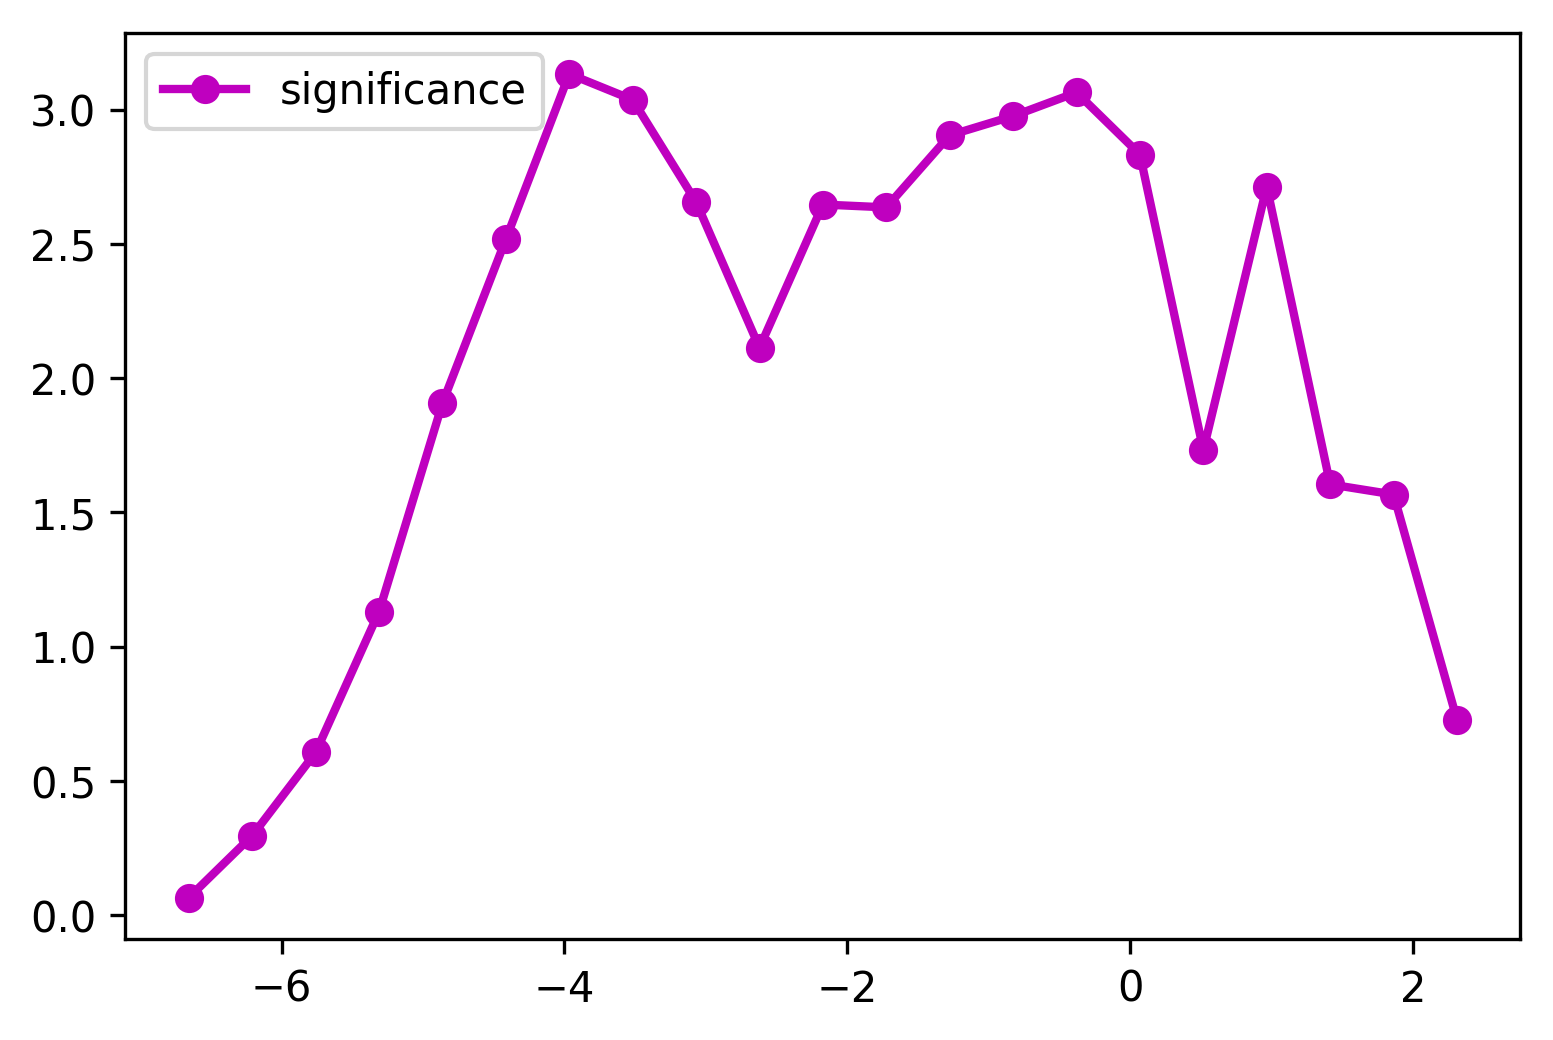

/home/janik/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in divide
/home/janik/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide


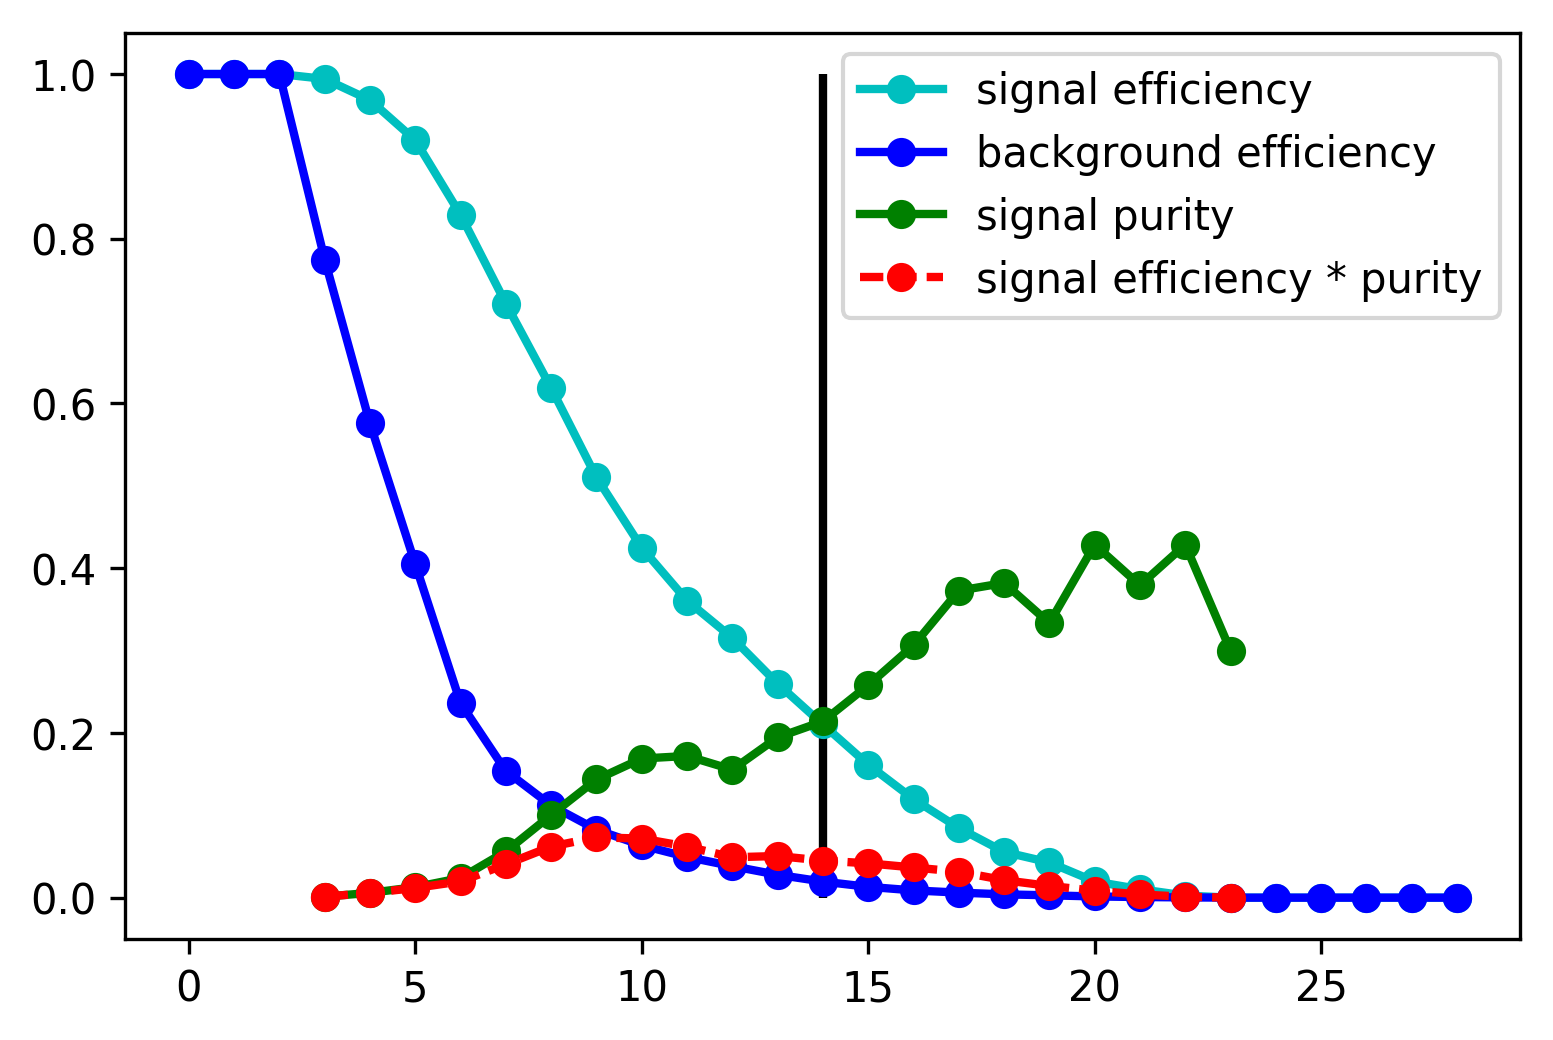

In [20]:
plt.plot(binning[:-1],1.*N_sig/(np.sqrt(N_sig + N_bkg + N_bkg)),'mo-',label='significance')
print binning[:-1][np.argmax(1.*N_sig/(np.sqrt(N_sig + N_bkg + N_bkg)))]
#plt.plot(np.sqrt(-2*(N_sig+N_bkg)*np.log(1+N_sig/N_bkg) + 2*N_sig),'ro--', label='lr significance')
#plt.hlines(3.,0,30)
#plt.vlines(14,0,7)
plt.legend()
plt.show()

plt.vlines(14,0,1)
plt.plot(1.-(np.array(sum_sig_cuts))/norm_sig,'co-',label='signal efficiency')
plt.plot(1.-(np.array(sum_bkg_cuts))/norm_bkg,'bo-',label='background efficiency')
plt.plot(1.*N_sig / (N_sig+N_bkg),'go-',label='signal purity')
plt.plot((1.*N_sig / (N_sig+N_bkg))*(1.-(np.array(sum_sig_cuts))/norm_sig),'ro--',label='signal efficiency * purity')
plt.legend()
plt.show()

In [33]:
cut = 1.41379310345

In [37]:
import cPickle
# save the classifier
with open('BDT_85higgs1.pkl', 'wb') as fid:
    cPickle.dump(grbcl, fid)    

# New stuff

In [7]:
#clean up unphysical or unkown input features
del df_mH80['irun']
del df_mH80['ievt']
del df_mH80['encm']
del df_mH80['ifi'] #no info
del df_mH80['idp1'] #no info
del df_mH80['idp2'] #no info
del df_mH80['ghmass']

del df_mH80['mvisf']




In [8]:
S_all = len(framesMC_HiggsModels[0])
print S_all

3353


In [9]:
#plt.hist(df_MC_noHiggs['idp1'],bins=100)
#plt.hist(framesMC_HiggsModels[0]['idp2'],bins=100)
#plt.show()

In [10]:
def PrintSelectionEff (frame, S_tot) :
    S_cut = len(frame[frame['class']==1])
    B_cut = len(frame[frame['class']==0])
    
    eff = 1.* S_cut / S_tot
    purity = 1.* S_cut / (S_cut + B_cut) 
    signal_strength = 1.*S_cut / B_cut
    
    print ('efficiency: ', eff)
    print ('purity: ', purity)
    print ('signal strength: ', signal_strength)

In [11]:
def SelectionCut (dataframe, mH_hypo = 85) :
    
    #dataframe = dataframe[dataframe['btag1']>0.15]
    bvalue = 0.18
    
    
    dataframe = dataframe[(dataframe['btag1']>bvalue) | (dataframe['btag2']>bvalue)]
    dataframe = dataframe[(dataframe['mmis']>65)]
    dataframe = dataframe[(dataframe['mvis']<mH_hypo+5)]
    dataframe = dataframe[(dataframe['fmvis']<mH_hypo+5)]
    dataframe = dataframe[(dataframe['mvissc']<mH_hypo+5)]
    
    dataframe = dataframe[(dataframe['ucsdbt0']>1.4)]
    
    
    #dataframe = dataframe[dataframe['btag2']>0.15]
    #dataframe = dataframe[dataframe['acthm']<0.85]
    #dataframe = dataframe[dataframe['mmis']>80]
    
    
    return dataframe

In [12]:
#df_MC_noHiggs = pd.concat(framesMC_NoHiggs)
#df_mH80 = pd.concat([df_MC_noHiggs,framesMC_HiggsModels[0]])

df_mH80 = SelectionCut(dataframe=df_mH80)
PrintSelectionEff(frame=df_mH80,S_tot=S_all)

('efficiency: ', 0.520131225767969)
('purity: ', 0.30752953623699525)
('signal strength: ', 0.44410491469315)


In [13]:
col = df_mH80.columns
print col
a = [u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis',
       u'fth1', u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2']
print a

Index([u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis',
       u'fth1', u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi', u'weight', u'class'],
      dtype='object')
[u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis', u'fth1', u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1', u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2']


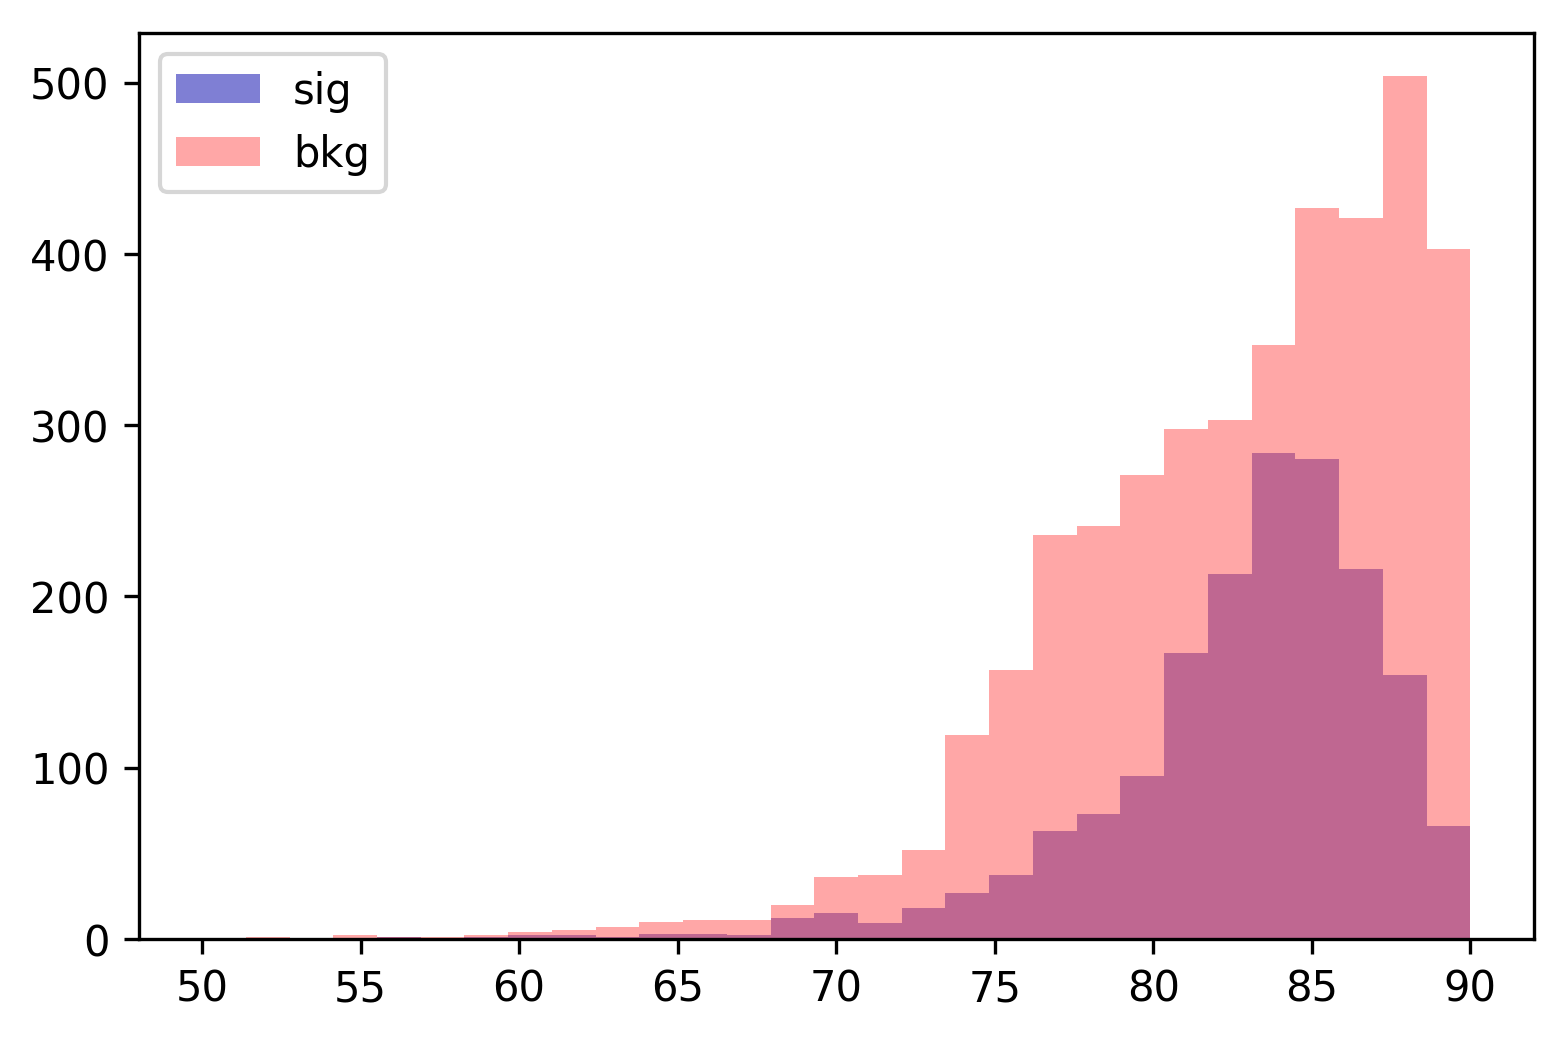

In [14]:
binning = np.linspace(50,90,30)
plt.hist(df_mH80[df_mH80['class']==1]['fmvis'],label='sig',alpha=0.5,bins=binning,normed=False)
plt.hist(df_mH80[df_mH80['class']==0]['fmvis'],label='bkg',alpha=0.5,bins=binning,normed=False)
plt.legend()
plt.show()

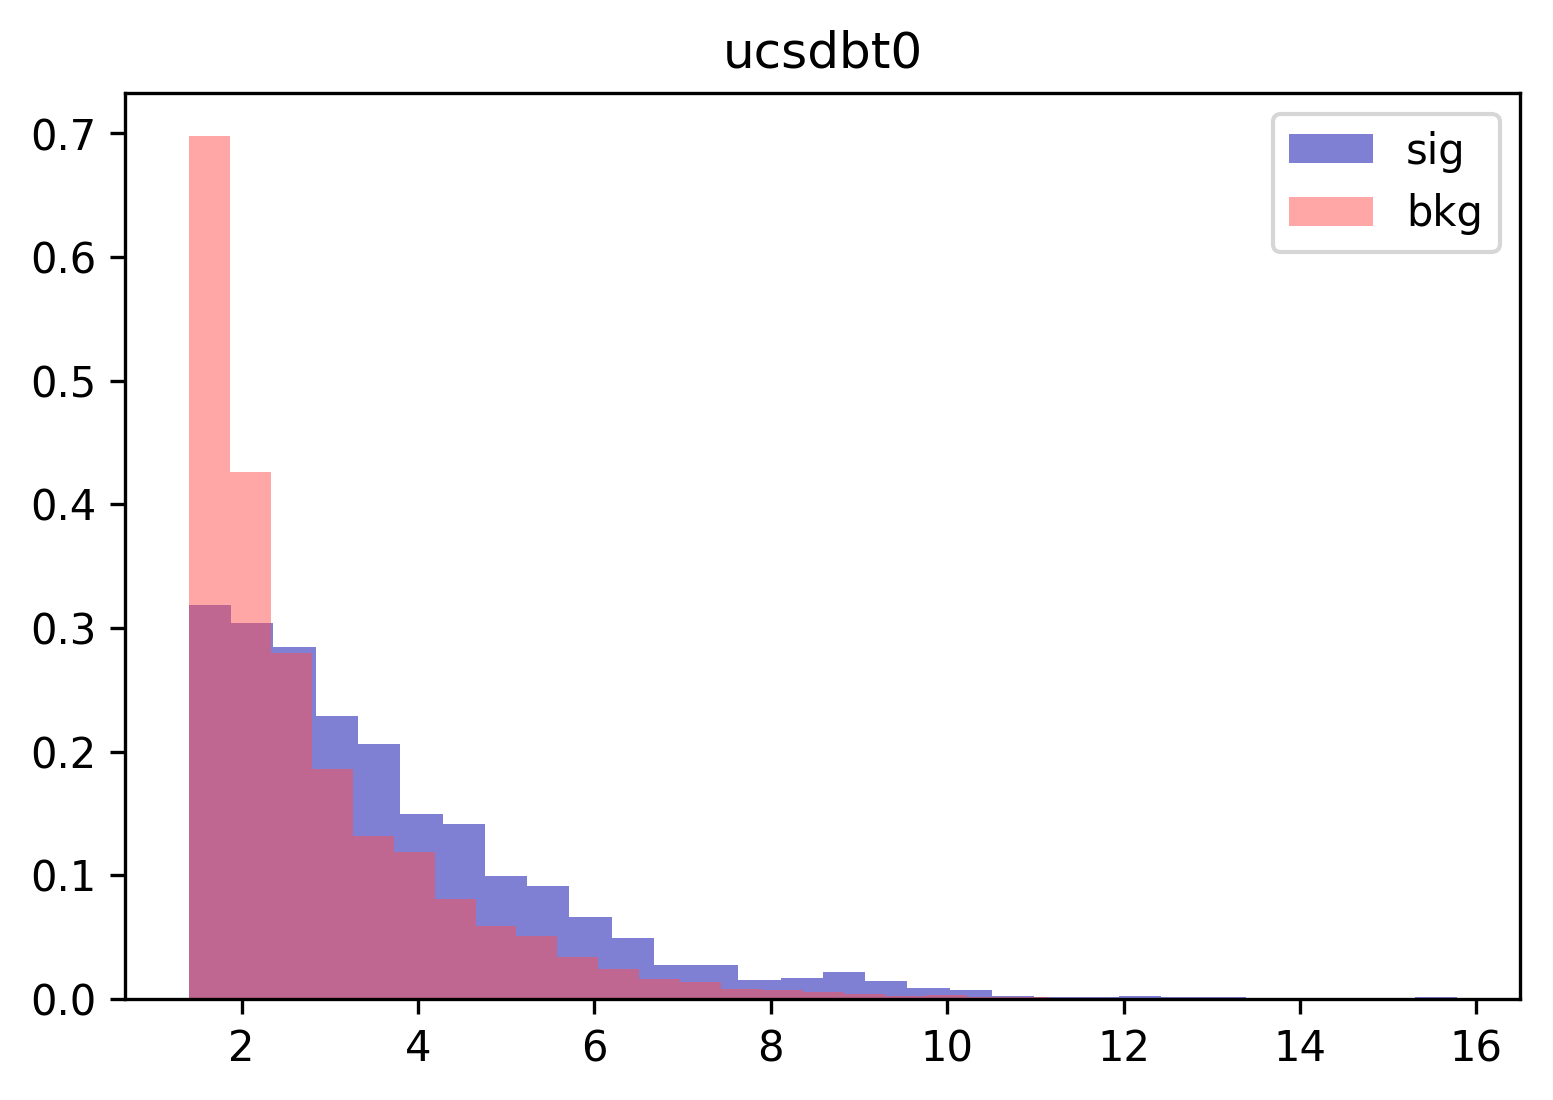

In [15]:
a = ['ucsdbt0']
for var in a:
    plt.title(var)
    plt.hist(df_mH80[df_mH80['class']==1][var],label='sig',alpha=0.5,bins=30,normed=True)
    plt.hist(df_mH80[df_mH80['class']==0][var],label='bkg',alpha=0.5,bins=30,normed=True)
    plt.legend()
    plt.show()

In [16]:
target = df_mH80['class']
del df_mH80['class']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_mH80, target, stratify=target, random_state=42,
                                                   train_size=0.75)
X_train_w = X_train['weight']
X_test_w = X_test['weight']

print(len(y_train))
print(np.count_nonzero(y_train))

print(1 - 1.*np.count_nonzero(y_train) / len(y_train))

print(len(y_test))
print(np.count_nonzero(y_test))

print(1 - 1.*np.count_nonzero(y_test) / len(y_test))


del X_train['weight']
del X_test['weight']



4253
1308
0.692452386551
1418
436
0.692524682652


In [18]:
logreg = LogisticRegression(C=100).fit(X_train, y_train,sample_weight=X_train_w)
SVM = LinearSVC(C=50).fit(X_train, y_train,sample_weight=X_train_w)


In [19]:
print X_train_w.values

[ 0.001  0.001  0.001 ...,  0.004  0.006  0.001]


In [20]:
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

print("Training set score: {:.3f}".format(SVM.score(X_train, y_train)))
print("Test set score: {:.3f}".format(SVM.score(X_test, y_test)))


Training set score: 0.655
Test set score: 0.659
Training set score: 0.308
Test set score: 0.308


NameError: name 'tree' is not defined

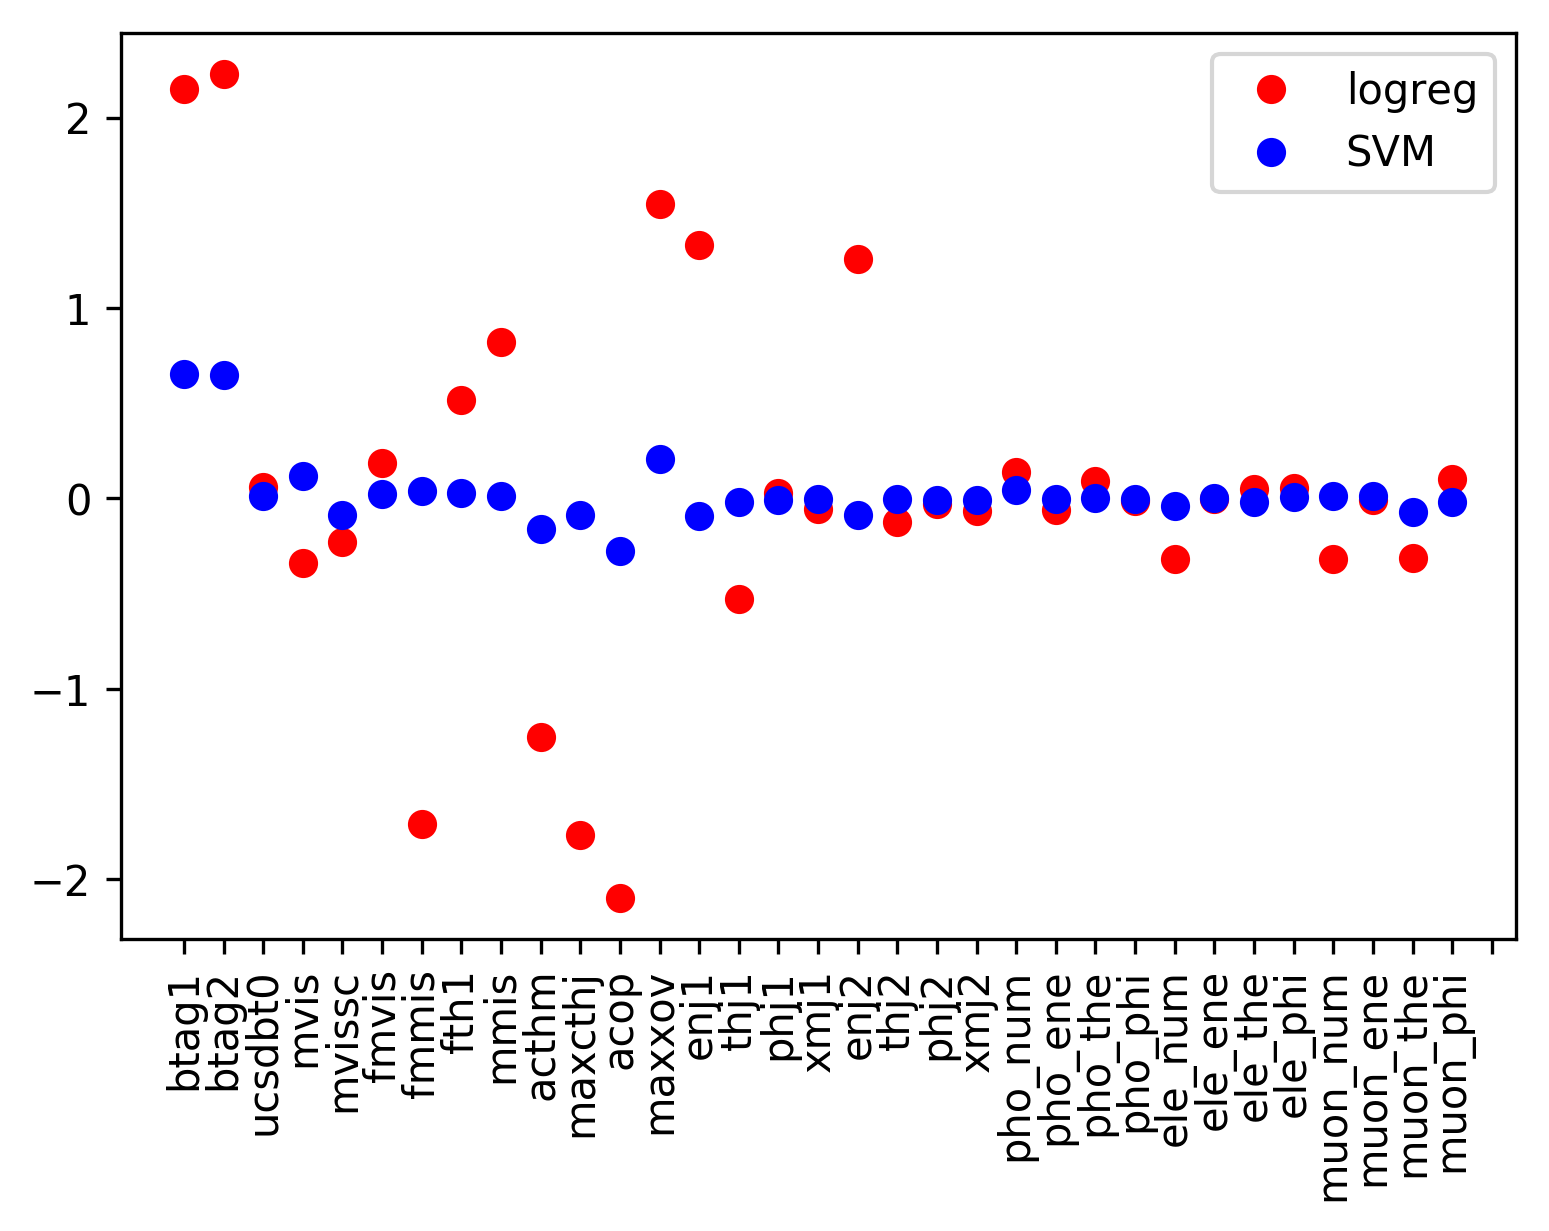

In [22]:
#plt.figure(figsize=(3,3))
plt.plot(logreg.coef_.T,'ro',label='logreg')
plt.plot(SVM.coef_.T,'bo',label='SVM')

#plt.plot(tree.coef_.T,'bo',label='tree')

plt.xticks(range(df_mH80.shape[1]),X_train.columns,rotation=90)
plt.legend()
plt.show()

In [23]:
for l in logreg.coef_ :
    print(l)

[ 2.151  2.227  0.06  -0.341 -0.23   0.188 -1.707  0.518  0.821 -1.254
 -1.766 -2.097  1.548  1.331 -0.528  0.03  -0.056  1.256 -0.124 -0.032
 -0.068  0.139 -0.058  0.092 -0.015 -0.315 -0.002  0.05   0.057 -0.316
 -0.007 -0.314  0.099]


In [24]:
X_train.columns

Index([u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis',
       u'fth1', u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi'],
      dtype='object')

In [37]:
tree = DecisionTreeClassifier(max_depth=2,random_state=0)
tree.fit(X_train,y_train,sample_weight=X_train_w.values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [38]:
from sklearn.tree import export_graphviz
import graphviz

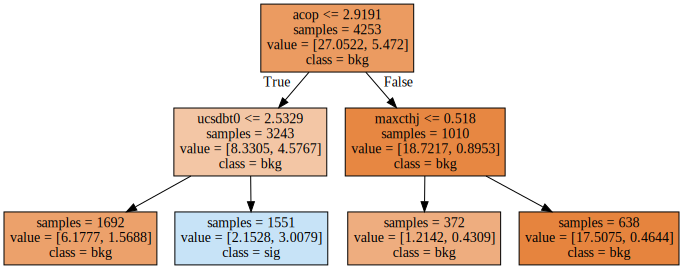

In [39]:
export_graphviz(tree,out_file='tree.dot',class_names=['bkg','sig'],feature_names=X_train.columns,
               impurity=False,filled=True)

with open('tree.dot') as f :
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
print np.shape(logreg.coef_[0])

In [ ]:
for i in logreg.coef_[0] :
    print i

### distribution of variable of interest

In [ ]:
def GetHistogram (df, column, binning) :
  
    return np.histogram(a=df[column],
                        bins = binning,
                        weights=df['weight'])[0]

In [ ]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [ ]:

"""variable_dict = {variable: 'mmis', 
                           'acop',
                           'acthm',
                           'fmvis',
                             'mvis'
    
                }
x_name_dict = { x_name: r'missing mass $m_\mathrm{mis}$',  
                        r'$\pi -$ angles btw jets',
                        r'$|\cos(\phi_\mathrm{polar,pmiss})|$',
                        r'visible mass (Z-adjusted) $m_\mathrm{vis}$',
               r'visible mass $m_\mathrm{vis}$'
    
}

x_unit_dict = { x_unit: r'$\mathrm{GeV} / \mathrm{c}^2$',
                        r'$\mathrm{rad}$',
                        r'$1$',
                        r'GeV',
               r'GeV'
    
}
binning_dict = { binning: np.linspace(50.,130.,20),
                          np.linspace(1.5,np.pi,30),
                          np.linspace(0,1.,20),
                          np.linspace(60,100,20),
                np.linspace(70,100,12)
    
}"""

In [ ]:
path = '/home/janik/StatMethods/Project/plots/VariableDists/'
ensure_dir(file_path=path)
variable = 'ucsdbt0'
x_name = r'b tag special'
x_unit = r'1'
binning = np.append(np.linspace(0,8,10),np.array([10,14]))
save_path = path+variable

In [ ]:
bkg = np.zeros(len(binning)-1)
for dataframe in framesMC_NoHiggs :
    bkg += GetHistogram(df=dataframe,column=variable,binning=binning)

sigModels = [] 
for dataframe in framesMC_HiggsModels :
    sigModels.append(GetHistogram(df=dataframe,column=variable,binning=binning))
    

data_hist = GetHistogram(df=data,column=variable,binning=binning)

In [ ]:
pl.BkgSigHistos(background=bkg,signals=sigModels,data=data_hist,variable_binning=binning,
                x_label=[x_name,x_unit],savepath=None)#save_path)

## The Log-likelihood ratio we define to be

$$
    -2 \log (Q(m_H)) = 2 s_{tot} - 2 \sum_{i=1}^{N_{bins}} N_i \log \left( 1 + \frac{s_i(m_H)}{b_i} \right)
$$

In [ ]:
import stats as stat
reload(stat)

In [ ]:
llr_85 = stat.LogLikRatio(background=bkg,signal=sigModels[0],N_experiments=10000)
llr_90 = stat.LogLikRatio(background=bkg,signal=sigModels[1],N_experiments=10000)
llr_95 = stat.LogLikRatio(background=bkg,signal=sigModels[2],N_experiments=10000)

llr_obs = stat.LogLikRatioObserved(background=bkg,signals=sigModels,data=data_hist)

In [ ]:
path = '/home/janik/StatMethods/Project/plots/loglikeliratio/'
ensure_dir(file_path=path)
save_path = path+variable

In [ ]:
reload(pl)
pl.LogLikRatioPlots([llr_85,llr_90,llr_95],Nbins=100,obs=llr_obs,savepath=None)#save_path)


stuff to try

## Go 2D :-)


In [ ]:
def GetHistogram2D (df, columns, binnings) :
  
    return np.histogram2d(x=df[columns[0]],
                          y=df[columns[1]],
                        bins = [binnings[0],binnings[1]],
                        weights=df['weight']
                         )[0]

In [ ]:
path = '/home/janik/StatMethods/Project/plots/VariableDists_2D/'
ensure_dir(file_path=path)
var1 = 'mvissc'
x_name1 = r'visible mass rescaled'
x_unit1 = r'GeV'
binning1 = np.linspace(0,140,10)

var2 = 'btag1'
x_name2 = r' b tag jet 1'
x_unit2 = r'1'
binning2 = np.linspace(0,1,10)


save_path = path+var1+var2

In [ ]:
bkg = np.zeros((len(binning1)-1,len(binning2)-1))
for dataframe in framesMC_NoHiggs :
    bkg += GetHistogram2D(df=dataframe,columns=[var1,var2],
                          binnings=[binning1,binning2])

   
sigModels = [] 
for dataframe in framesMC_HiggsModels :
    sigModels.append(GetHistogram2D(df=dataframe,
                                    columns=[var1,var2],
                                    binnings=[binning1,binning2]))
    

data_hist = GetHistogram2D(df=data,columns=[var1,var2],
                           binnings=[binning1,binning2])

In [ ]:
plt.imshow(bkg)
plt.show()

for i in xrange(3) :
    plt.imshow(sigModels[i])
    plt.show()

plt.imshow(data_hist)
plt.show()
    

In [ ]:
b = bkg
s = sigModels[0]
s_tot = s.sum()

llr_b_like = []
llr_sPlusb_like = []
N_exp = 10000

for k in xrange(N_exp) :
    N = np.random.poisson(lam=b)
    llr_b_like.append(2*s_tot - 2*np.dot(N,np.log(1+s/b)))

for k in xrange(N_exp) :
    N = np.random.poisson(lam=(s+b))
    llr_sPlusb_like.append(2*s_tot - 2*np.dot(N,np.log(1+s/b)))
    
    


In [ ]:
plt.hist(llr_b_like,40,color='blue',alpha=0.5,label='bkg-like',normed=True)
plt.hist(llr_sPlusb_like,40,color='red',alpha=0.5,label='sig+bkg-like',normed=True)
plt.xlabel(r'$-2 \log (Q)$')
plt.ylabel('p.d.f.')
plt.legend()
plt.show()


In [ ]:
q = np.random.poisson(lam=[10,100])
print(q)

In [ ]:
def LogLikRatio (background, signal, N_experiments=10000) :
    
           
    b = background
    s = signal
    s_tot = s.sum()
    
    llr_b_like = []
    llr_sPlusb_like = []

    for k in xrange(N_experiments) :
        N_b = np.random.poisson(lam=b)
        N_sPlusb = np.random.poisson(lam=(s+b))

        llr_b_like.append(2*s_tot - 2*np.dot(N_b,np.log(1+s/b)))
        llr_sPlusb_like.append(2*s_tot - 2*np.dot(N_sPlusb,np.log(1+s/b)))
    
    return llr_b_like, llr_sPlusb_like
        


In [ ]:
bkg = GetHistogram(qq,column=variable,binning=binning)

In [ ]:
print(len(binning))
print(len(bkg))

print(binning)
print(bkg)
binw = binning[1]-binning[0]
plt.bar(binning[:-1]+binw/2.,bkg,width=binw)
plt.show()

In [ ]:
a = qq.groupby(variable)['weight'].sum()

plt.hist(a)
plt.show()

In [ ]:
for col in qq.columns :
    print(col)

In [ ]:
for col in data :
    print(col)